In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import ComplementNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, multilabel_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import FunctionTransformer
import joblib, json, matplotlib.pyplot as plt, seaborn as sns

import numpy as np, pandas as pd, joblib
from pathlib import Path
from sklearn.preprocessing   import MultiLabelBinarizer
from sklearn.multiclass      import OneVsRestClassifier

from xgboost import XGBClassifier 
from lightgbm import LGBMClassifier

from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble      import RandomForestClassifier

RANDOM = 42

# Preprocessing

In [2]:
train_df = pd.read_json("../data/craft-ml-data-train.jsonl", lines=True)
# train_df = train_df.explode("labels")
X_train = train_df["text"]
y_train = train_df["labels"].str[0]

test_df = pd.read_json("../data/craft-ml-data-test.jsonl", lines=True)
# test_df = test_df.explode("labels")
X_test = test_df["text"]
y_test = test_df["labels"].str[0]

# Single Class Baseline

I want to see how hard this is under a one label process then move to two labels

In [3]:
word_tfidf = TfidfVectorizer(
    stop_words="english",
    max_df=0.9,
    min_df=2,
    ngram_range=(1,2),
    dtype=np.float32
)

char_tfidf = TfidfVectorizer(
    analyzer="char",
    ngram_range=(3,5),
    min_df=2,
    dtype=np.float32
)

In [4]:
def make_pipeline(vec, clf, k_best=None):
    steps = [("vec", vec)]
    steps += [("clf", clf)]
    return Pipeline(steps)


In [5]:
baselines = {
    "LogReg_word" : make_pipeline(
        word_tfidf,
        LogisticRegression(max_iter=1000, class_weight="balanced", C=2.0)
    ),
    "SVM_word"    : make_pipeline(
        word_tfidf,
        LinearSVC(C=1.0, class_weight="balanced")
    ),
    "CompNB_word" : make_pipeline(
        word_tfidf,
        ComplementNB()
    ),
    # hybrid word+char union
    "LogReg_word+char" : make_pipeline(
        FeatureUnion([("word", word_tfidf), ("char", char_tfidf)]),
        LogisticRegression(max_iter=1000, class_weight="balanced", C=2.0)
    ),
}

for name, model in baselines.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n=== {name} ===")
    print(accuracy_score(y_test, y_pred))



=== LogReg_word ===
0.5125

=== SVM_word ===
0.5125

=== CompNB_word ===
0.3375

=== LogReg_word+char ===
0.5


### Takeaways
- Performance on single class isnt that good from simple baseline models
- Logistic Regression on words only tfidf performs best. pefromance worsens when adding in characters. 

# Multiclass Baseline with OneVsRest Classifier

In [6]:
X_train, y_train_r = train_df["text"].values, train_df["labels"].values

X_test, y_test_r = test_df["text"].values, test_df["labels"].values

mlb = MultiLabelBinarizer()

y_train = mlb.fit_transform(y_train_r)
y_test = mlb.transform(y_test_r)
y_train.shape, y_test.shape

((318, 9), (80, 9))

In [7]:
dense_vec = Pipeline([
    ("tfidf", TfidfVectorizer(
        stop_words="english",
        max_df=0.9,
        min_df=5,
        ngram_range=(1,2),
        dtype=np.float32
    )),
    ("svd", TruncatedSVD(n_components=100, random_state=RANDOM))
])

In [17]:
multi_clfs = {
    "OVR_LogReg": LogisticRegression(max_iter=1000, C=2.0, class_weight="balanced", random_state=RANDOM),
    "OVR_LinearSVC": LinearSVC(C=1.0, class_weight="balanced", random_state=RANDOM),

    "OVR_RF_500": RandomForestClassifier(random_state=RANDOM, class_weight="balanced"),
    "OVR_XGB": XGBClassifier(random_state=RANDOM), # Should have tried scale pos weight here
    # "OVR_LGBM": LGBMClassifier(random_state=RANDOM, class_weight = 'balanced', verbose = -1)

}

plot = False

for name, base_clf in multi_clfs.items():
    pipe = Pipeline([
        ("vec", dense_vec),
        ("clf", OneVsRestClassifier(base_clf, n_jobs=-1))
    ])

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    micro  = f1_score(y_test, y_pred, average="micro")
    macro  = f1_score(y_test, y_pred, average="macro")
    subset = accuracy_score(y_test, y_pred)

    print(f"{name:15s}  micro-F1: {micro:.3f}  macro-F1: {macro:.3f}  subset-Acc: {subset:.3f}")

    if plot:
        actual_counts = np.array(y_test).sum(axis=0)
        pred_counts = np.array(y_pred).sum(axis=0)
        labels = mlb.classes_

        mcm = multilabel_confusion_matrix(y_test, y_pred)
        top_idxs = np.argsort(actual_counts)[-10:]

        fig, axes = plt.subplots(1, len(top_idxs), figsize=(4*len(top_idxs), 4))
        for ax, idx in zip(axes, top_idxs):
            sns.heatmap(mcm[idx], annot=True, fmt='d', cmap='Blues', ax=ax)
            ax.set_title(f"Class: {labels[idx]}")
        plt.tight_layout()
        plt.show()

OVR_LogReg       micro-F1: 0.553  macro-F1: 0.559  subset-Acc: 0.300
OVR_LinearSVC    micro-F1: 0.556  macro-F1: 0.571  subset-Acc: 0.338
OVR_RF_500       micro-F1: 0.256  macro-F1: 0.216  subset-Acc: 0.175
OVR_XGB          micro-F1: 0.328  macro-F1: 0.251  subset-Acc: 0.250


In [9]:
baseline = Pipeline([
    ("vec", dense_vec),
    ("clf", OneVsRestClassifier(LogisticRegression(max_iter=1000, C=2.0, class_weight="balanced", random_state=RANDOM), n_jobs=-1))
])

baseline.fit(X_train, y_train)
y_pred = baseline.predict(X_test)
print(f"\n=== Baseline ===")        
baselien_report = classification_report(y_test, y_pred, target_names=mlb.classes_)
print(baselien_report)



=== Baseline ===
                                         precision    recall  f1-score   support

                                   None       0.39      0.52      0.45        25
                epidemics_and_pandemics       0.62      0.83      0.71         6
                     financial_distress       0.50      0.57      0.53         7
                      financial_success       0.25      0.25      0.25         4
                    geopolitical_issues       0.57      0.44      0.50         9
                            investments       0.40      0.50      0.44         8
labor_workforce_compliance_human_rights       0.80      0.73      0.76        11
                      natural_disasters       0.62      0.83      0.71         6
                            supplychain       0.67      0.67      0.67        12

                              micro avg       0.52      0.59      0.55        88
                              macro avg       0.54      0.59      0.56        88
        

/opt/anaconda3/envs/document-tagger/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Takeaways

Baseline Logistic Regression model has micro-f1 of .55. this is still not very good

# scikit-multilearn similarity

In [10]:
from skmultilearn.adapt import MLkNN

In [11]:
X_train, y_train_r = train_df["text"].values, train_df["labels"].values

X_test, y_test_r = test_df["text"].values, test_df["labels"].values

mlb = MultiLabelBinarizer()

y_train = mlb.fit_transform(y_train_r)
y_test = mlb.transform(y_test_r)
y_train.shape, y_test.shape


((318, 9), (80, 9))

In [12]:
from sklearn.neighbors import NearestNeighbors as _NN
import skmultilearn.adapt.mlknn as _mlknn
from skmultilearn.adapt import MLkNN

_mlknn.NearestNeighbors = lambda n_neighbors, **kw: _NN(n_neighbors=n_neighbors, **kw)

pipe = Pipeline([
    ("vec", dense_vec),
    ("clf", MLkNN(k=3))
])
pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)

dlr = classification_report(y_test, y_pred, target_names=mlb.classes_)

print(dlr)

                                         precision    recall  f1-score   support

                                   None       0.42      0.40      0.41        25
                epidemics_and_pandemics       0.33      0.17      0.22         6
                     financial_distress       0.25      0.14      0.18         7
                      financial_success       0.25      0.25      0.25         4
                    geopolitical_issues       0.33      0.33      0.33         9
                            investments       1.00      0.12      0.22         8
labor_workforce_compliance_human_rights       0.67      0.18      0.29        11
                      natural_disasters       0.40      0.33      0.36         6
                            supplychain       0.67      0.50      0.57        12

                              micro avg       0.44      0.31      0.36        88
                              macro avg       0.48      0.27      0.32        88
                          

/opt/anaconda3/envs/document-tagger/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Takeaway

Does not outperform baseline and requires hot fix to revert to older version of sklearn

# PreTrained Sentence Transformer

In [18]:
from sentence_transformers import SentenceTransformer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

embedder = SentenceTransformer("all-MiniLM-L6-v2")

X_tr_sbert = embedder.encode(X_train, 
                             batch_size=32, 
                             show_progress_bar=False, 
                             convert_to_numpy=True)

X_te_sbert = embedder.encode(X_test,  
                             batch_size=32, 
                             show_progress_bar=False, 
                             convert_to_numpy=True)

print("Train embed shape:", X_tr_sbert.shape)



/opt/anaconda3/envs/document-tagger/lib/python3.10/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/opt/anaconda3/envs/document-tagger/lib/python3.10/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Train embed shape: (318, 384)


In [14]:
clf = OneVsRestClassifier(
    LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        random_state=42,
        C=.1
    ), 
    n_jobs=-1
)
clf.fit(X_tr_sbert, y_train)

y_pred = clf.predict(X_te_sbert)
print(classification_report(y_test, y_pred, target_names=mlb.classes_))

                                         precision    recall  f1-score   support

                                   None       0.44      0.68      0.53        25
                epidemics_and_pandemics       0.57      0.67      0.62         6
                     financial_distress       0.35      0.86      0.50         7
                      financial_success       0.31      1.00      0.47         4
                    geopolitical_issues       0.47      0.78      0.58         9
                            investments       0.40      0.75      0.52         8
labor_workforce_compliance_human_rights       0.64      0.82      0.72        11
                      natural_disasters       0.45      0.83      0.59         6
                            supplychain       0.44      0.67      0.53        12

                              micro avg       0.44      0.75      0.56        88
                              macro avg       0.45      0.78      0.56        88
                          

/opt/anaconda3/envs/document-tagger/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Takeaway
Performance did improve. Concerned about model complexity now with so many features and so few documents

# PCA reduction

In [19]:
from sklearn.decomposition import PCA

pca = PCA(n_components=100, random_state=42)
X_tr_pca = pca.fit_transform(X_tr_sbert)
X_te_pca = pca.transform(X_te_sbert)

clf = OneVsRestClassifier(
    LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        random_state=RANDOM,
        C=.1
    ), 
    n_jobs=-1
)
clf.fit(X_tr_pca, y_train)

y_pred = clf.predict(X_te_pca)
print(classification_report(y_test, y_pred, target_names=mlb.classes_))

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

                                         precision    recall  f1-score   support

                                   None       0.42      0.64      0.51        25
                epidemics_and_pandemics       0.57      0.67      0.62         6
                     financial_distress       0.33      0.86      0.48         7
                      financial_success       0.31      1.00      0.47         4
                    geopolitical_issues       0.47      0.78      0.58         9
                            investments       0.40      0.75      0.52         8
labor_workforce_compliance_human_rights       0.64      0.82      0.72        11
                      natural_disasters       0.45      0.83      0.59         6
                            supplychain       0.39      0.58      0.47        12

                              micro avg       0.43      0.73      0.54        88
                              macro avg       0.44      0.77      0.55        88
                          

/opt/anaconda3/envs/document-tagger/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


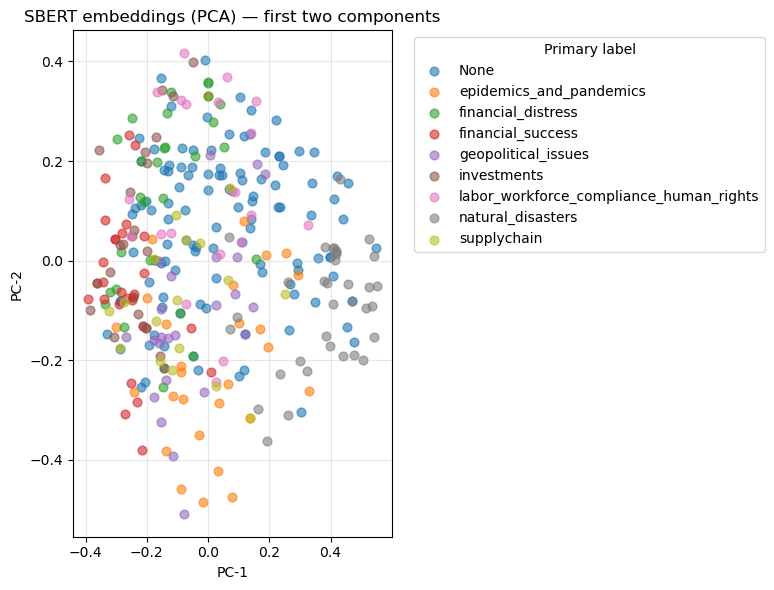

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

X_show   = X_tr_pca            # or X_tr_pca
y_show   = y_train              # or y_train

primary_lab = [mlb.classes_[row.nonzero()[0][0]]
               if row.any() else 'None'
               for row in y_show]

# pull the first two PCs
pc1, pc2 = X_show[:, 0], X_show[:, 1]

fig, ax = plt.subplots(figsize=(8, 6))

for lbl in np.unique(primary_lab):
    mask = np.array(primary_lab) == lbl
    ax.scatter(pc1[mask], pc2[mask],
               label=lbl, alpha=0.6, s=40)

ax.set_xlabel('PC-1')
ax.set_ylabel('PC-2')
ax.set_title('SBERT embeddings (PCA) — first two components')
ax.legend(title='Primary label', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3)
plt.tight_layout()


### Takeaway
Dont loose too much signal by reducing feature space. Worth considering

In [25]:
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

pca = PCA(n_components=100, random_state=42)
X_tr_pca = pca.fit_transform(X_tr_sbert)
X_te_pca = pca.transform(X_te_sbert)

clf = OneVsRestClassifier(
    KNeighborsClassifier(
        n_neighbors=5
    ), 
    n_jobs=-1
)
clf.fit(X_tr_pca, y_train)

y_pred = clf.predict(X_te_pca)
print(classification_report(y_test, y_pred, target_names=mlb.classes_))

                                         precision    recall  f1-score   support

                                   None       0.50      0.40      0.44        25
                epidemics_and_pandemics       0.67      0.67      0.67         6
                     financial_distress       1.00      0.29      0.44         7
                      financial_success       0.40      0.50      0.44         4
                    geopolitical_issues       0.75      0.33      0.46         9
                            investments       0.00      0.00      0.00         8
labor_workforce_compliance_human_rights       1.00      0.45      0.62        11
                      natural_disasters       0.60      0.50      0.55         6
                            supplychain       0.75      0.25      0.38        12

                              micro avg       0.62      0.36      0.46        88
                              macro avg       0.63      0.38      0.45        88
                          

/opt/anaconda3/envs/document-tagger/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
